# Logistic Regression

## Setup

In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn.functional as F

from src.data import DataLoader
from src.trainer import Trainer
from src.optimizers import SGD
from src.metrics import Accuracy
from src.losses import CrossEntropyLoss

## Preprocessing

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
mnist_trainset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
mnist_testset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

# Transform the training data
X_train = mnist_trainset.data.float() / 255.0
X_train = X_train.view(X_train.shape[0], -1)
y_train = mnist_trainset.targets

# Transform the test data
X_val = mnist_testset.data.float() / 255.0
X_val = X_val.view(X_val.shape[0], -1)
y_val = mnist_testset.targets

train_dataloader = DataLoader(X_train, y_train, batch_size=256, shuffle=True)
val_dataloader = DataLoader(X_val, y_val, batch_size=256, shuffle=False)

## Theoretical Background

## ReLU from Scratch

In [3]:
import torch
import torch.nn as nn

def relu(x):
    # Apply ReLU: max(x, 0) for each element in x.
    out = torch.maximum(x, torch.zeros(1))
    return out

# Test input tensor
x = torch.tensor([-1.0, 0.5, -0.2, 2.0])

# Apply custom ReLU
custom_output = relu(x)

# Apply PyTorch's ReLU
pytorch_output = F.relu(x)

# Compare outputs
are_equal = torch.equal(custom_output, pytorch_output)
print(f"Are the custom ReLU and PyTorch ReLU outputs equal? {are_equal}")


Are the custom ReLU and PyTorch ReLU outputs equal? True


## Multilayer Perceptron From Scratch

Our network will have 2 hidden layers.

- W1: X with shape (num_samples, in_features) will be transformed by W1 (in_features, num_units) to Z1 with shape (num_samples, num_units).
- b1: b1 will be added to the matrix product of X and W1 which will be size (num_samples, num_units), so we will make it shape (num_units).
- W2: A1 with shape (num_samples, num_units) will be transformed by W2 (num_units, num_outpurs) to Z2 with shape (num_samples, num_classes).
- b2: b2 will be added to the matrix product of A1 and W2 which will be size (num_samples, num_classes), so we will make it shape (num_classes).

### Simple Training Loop

In [4]:
# Create a batch
batch_size = 128
perm = torch.randperm(len(X_train))
X_batch = X_train[perm][:batch_size]
y_batch = y_train[perm][:batch_size]

in_features = X_train.shape[1]
num_units = 256
num_classes = y_train.unique().shape[0]

W1 = nn.Parameter(torch.randn(in_features, num_units) * 0.01)
b1 = nn.Parameter(torch.zeros(num_units))
W2 = nn.Parameter(torch.randn(num_units, num_classes) * 0.01)
b2 = nn.Parameter(torch.zeros(num_classes))

parameters = [W1, b1, W2, b2]
optimizer = SGD(parameters, lr=0.5)
cross_entropy = CrossEntropyLoss()

In [5]:
num_epochs = 3
for epoch in range(num_epochs):
    total_loss = 0
    for batch in train_dataloader:
        inputs, targets = batch
    
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        Z1 = X_batch @ W1 + b1
        A1 = F.relu(Z1)
        Z2 = A1 @ W2 + b2
        y_pred = F.softmax(Z2)
        
        # Calculate Loss
        loss = cross_entropy(y_pred, y_batch)
        
        # Backward pass (compute gradients)
        loss.backward()
        
        # Update parameters
        optimizer.step()
        total_loss += loss.item()

    print(total_loss / len(train_dataloader))

C:\Users\woute\AppData\Local\Temp\ipykernel_1036\3884870822.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = F.softmax(Z2)


0.16898863896569039
0.0026013047677127922
0.0012978705399213954


### Define Training Loop and Model

In [6]:
class MLP(nn.Module):
    def __init__(self, in_features, num_classes, num_units):
        super().__init__()
        self.num_classes = num_classes
        self.W1 = nn.Parameter(torch.randn(in_features, num_units) * 0.01)
        self.b1 = nn.Parameter(torch.zeros(num_units))
        self.W2 = nn.Parameter(torch.randn(num_units, num_classes) * 0.01)
        self.b2 = nn.Parameter(torch.zeros(num_classes))

    def forward(self, X):
        # Forward pass
        Z1 = X @ self.W1 + self.b1
        A1 = F.relu(Z1)
        Z2 = A1 @ self.W2 + self.b2
        y_pred = F.softmax(Z2)
        return y_pred

    def parameters(self):
        return [self.W1, self.b1, self.W2, self.b2]

### Define Training Loop and Model

C:\Users\woute\AppData\Local\Temp\ipykernel_1036\765667640.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = F.softmax(Z2)


Epoch 1/20, Training Loss: 0.6058, Validation Loss: 0.3039
Validation accuracy: 0.9138
Epoch 2/20, Training Loss: 0.2656, Validation Loss: 0.2174
Validation accuracy: 0.9358
Epoch 3/20, Training Loss: 0.2045, Validation Loss: 0.1869
Validation accuracy: 0.9447
Epoch 4/20, Training Loss: 0.1657, Validation Loss: 0.1518
Validation accuracy: 0.9545
Epoch 5/20, Training Loss: 0.1390, Validation Loss: 0.1318
Validation accuracy: 0.9609
Epoch 6/20, Training Loss: 0.1195, Validation Loss: 0.1135
Validation accuracy: 0.9652
Epoch 7/20, Training Loss: 0.1052, Validation Loss: 0.1043
Validation accuracy: 0.9668
Epoch 8/20, Training Loss: 0.0927, Validation Loss: 0.1035
Validation accuracy: 0.9687
Epoch 9/20, Training Loss: 0.0836, Validation Loss: 0.0907
Validation accuracy: 0.9725
Epoch 10/20, Training Loss: 0.0754, Validation Loss: 0.0844
Validation accuracy: 0.9744
Epoch 11/20, Training Loss: 0.0685, Validation Loss: 0.0854
Validation accuracy: 0.9751
Epoch 12/20, Training Loss: 0.0632, Valid

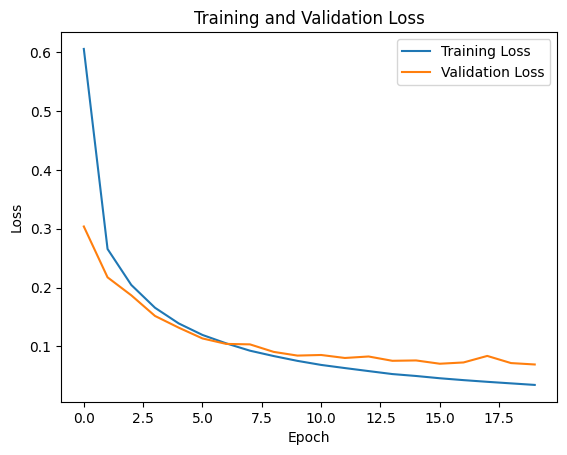

In [7]:
in_features = X_train.shape[1]
num_classes = y_train.unique().shape[0]
num_units = 256
num_epochs = 20
learning_rate = 0.3

model = MLP(in_features, num_classes, num_units)
optimizer = SGD(model.parameters(), lr=learning_rate)
criterion = CrossEntropyLoss()
metrics = {'accuracy': Accuracy()}
trainer = Trainer(model, train_dataloader, val_dataloader, optimizer, criterion, custom_metrics=metrics)
trainer.fit(num_epochs=num_epochs)

## Concise Implementation of MLP

Epoch 1/10, Training Loss: 0.4310, Validation Loss: 0.2159
Validation accuracy: 0.9357
Epoch 2/10, Training Loss: 0.1871, Validation Loss: 0.1638
Validation accuracy: 0.9485
Epoch 3/10, Training Loss: 0.1349, Validation Loss: 0.1244
Validation accuracy: 0.9637
Epoch 4/10, Training Loss: 0.1057, Validation Loss: 0.1010
Validation accuracy: 0.9680
Epoch 5/10, Training Loss: 0.0876, Validation Loss: 0.0844
Validation accuracy: 0.9751
Epoch 6/10, Training Loss: 0.0737, Validation Loss: 0.0880
Validation accuracy: 0.9743
Epoch 7/10, Training Loss: 0.0638, Validation Loss: 0.0765
Validation accuracy: 0.9762
Epoch 8/10, Training Loss: 0.0563, Validation Loss: 0.0725
Validation accuracy: 0.9778
Epoch 9/10, Training Loss: 0.0492, Validation Loss: 0.0971
Validation accuracy: 0.9683
Epoch 10/10, Training Loss: 0.0438, Validation Loss: 0.0622
Validation accuracy: 0.9794


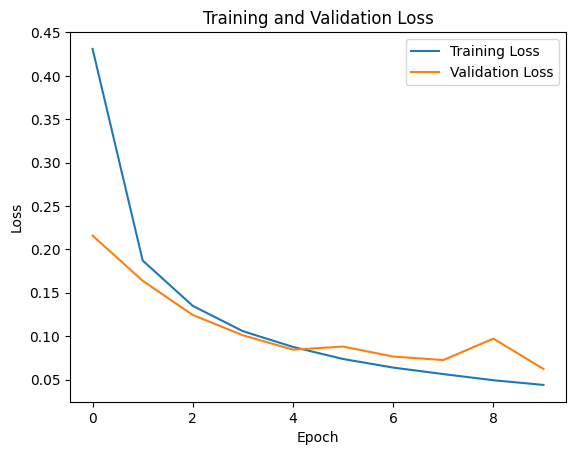

In [8]:
# Assuming X and y are your feature and target tensors
# Split Data into Train and Test Sets
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)

# Define DataLoader
batch_size = 256
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

class MLP(nn.Module):
    def __init__(self, in_features, num_classes, num_units):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features, num_units)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(num_units, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

in_features = X_train.shape[1]
num_classes = y_train.unique().shape[0]
num_units = 256
model = MLP(in_features, num_classes, num_units)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.5)
metrics = {'accuracy': Accuracy()}
trainer = Trainer(model, train_dataloader, val_dataloader, optimizer, criterion, custom_metrics=metrics)
trainer.fit(num_epochs=10)